<a href="https://colab.research.google.com/github/tshjustin/A1_cartpole-v1/blob/main/SC3000_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SC3000 Assignment 1:

Justin Tan : U2221024B

Jared Ng: U2221802L

Amit: U2220363B

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.5 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


## Importing dependencies and define helper functions

In [4]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Firstly, we define the Cartpole problem and examine the format of `action space`, `observation space`

In [5]:
env = gym.make("CartPole-v1")
print(env.action_space) # Possible actions in the env
print(env.observation_space)

print("Number of features of the environment: ", env.observation_space.shape[0])

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Number of features of the environment:  4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1. Action Space: Discrete(2) means that there are two valid discrete actions: 0 & 1.


2. Observation Space: In the format: `[pos,velocity,angle,velocity]`. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

Now we explore performing an action in the environement and unpacking the values we obtain from a given action. This allows us to extract the features that we require when formulating the problem.

In [6]:
observation = env.reset()
print("Initial observations:", observation) # initial state values

observation, reward, done, info = env.step(0) # executes an action in the env
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done) # Done depends when one of the 3 conditions of termiantion are met

Initial observations: [ 0.01350721  0.02909834 -0.04511569 -0.04137247]
New observations after choosing action 0: [ 0.01408918 -0.1653486  -0.04594314  0.23674165]
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Task 1:

### Algorithm used
We used Deep Q networks to train the Agent due to the many possible position (States) of the agent. Although there are only 2 actions, the agent state represented as `[pos,velocity,angle,velocity]` have infinite states, thus using a Q table to store all the Q values would be computationally expensive.

Rather than keeping track of the Q value, we used DQN to obtain a function that estimate for the Q value, depending on the State of the agent.


### Pseudocode

        Initialize the Replay Memory

        Set a maximum size for the memory to store experiences.

        Initialize the Q-Network and Target Network with Random Weights

        For Each Episode:
          Initialize the environment and get the initial state
              For each time step or until the episode ends:
                  Use an epsilon-greedy policy for action selection:
                      With probability epsilon, select a random action;
                      Otherwise, choose the action with the highest Q-value as predicted by the Q-Network.
                  Execute the selected action in the environment.
                  Observe the next state and reward from the environment.
                  Store the experience (current state, action, reward, next state) in the Replay Memory.
                  Sample a random mini-batch of experiences from the Replay Memory.
                  For each experience in the mini-batch:
                      Calculate the target Q-value:
                          For non-terminal states: Target = reward + (discount rate * maximum Q-value of next state as predicted by the Target Network)
                          For terminal states: Target = reward
                      Update the Q-Network by minimizing the loss between its predicted Q-values and the calculated target Q-values.
                      Every fixed number of steps, update the Target Network with the weights of the Q-Network.

The primary update rule during training is using the temporal difference.
1. `Q-Network Prediction`: For a given state-action pair $Q(s,a)$, the Q-Network provides an estimate for it.

2. `Target-Network Prediction`: The target network provides a stable target for the next state. For the next state $s′$ resulting from taking action $a$, the Target Network is used to estimate the maximum future reward.
This is represented as $max_aQ(s′,a′)$

3. `Temporal Difference Target (TD Target)`: The TD Target is the sum of the immediate reward $r$ received after taking action $a$ in state $s$ plus the discounted maximum future reward predicted by the Target Network.
$TD = r + \gamma(max_aQ(s′,a′))$

4. The error is calculated as:  $r + \gamma(max_aQ(s′,a′)) - Q(s,a)$

## Key Objects

#### 1 Experience Replay

 This stores the agent's experiences at each time step, encapsulated in a tuple `(state, action, reward, next_state, done)`

 Methods would allow for sampling and storing of agent's experience during training.

#### 2 DQN Model
Defines the neural network that approximates the Q-function, mapping state-action pairs to expected rewards. The architecture consists of fully connected layers, with ReLU activation functions for non-linearity between layers.

Parameters:

`n_observations`: The size of the observation space, defining the input layer size.

`n_actions`: The size of the action space, defining the output layer size.

`n_layers`: The size of the hidden layers.


## Expected Inputs and Outputs for each object

### Network Model:

`Input Layer`: Consists of 4 neurons, each corresponding to one of the state's features (cart position, cart velocity, pole angle, pole velocity at the tip).


`Output Layer`: Consists of 2 neurons, each representing the Q-value for one of the possible actions (move left, move right).

### Experience Batch Processing
During training, batches of experience are passed into the model to break up sequential dependencies in episodes.

`Input Format`: A batch of experiences is represented as a 2D array with the shape [Batch Size, Number of Observations] => [[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], ...]

`Output Format`: For each observation in the batch, the network outputs a pair of Q-values corresponding to the actions 'move left' and 'move right': [[Q-value(action1), Q-value(action2)], [Q-value(action1), Q-value(action2)], ...].







In [7]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import random
from collections import deque

class Memory(object):
    def __init__(self, maxlen):
        self.memory = deque(maxlen=maxlen) # sets the maximum number of experiences - Oldeset entries removed while newest are placed at the end of the queue

    def store(self, experience):
        self.memory.append(experience) # adds an experience <state, action, reward, new state, done>

    def sample(self, n_samples):
        return zip(*random.sample(self.memory, n_samples)) # takes a random sample & transpose from [(state1, action1, reward1, next_state1, done1), (state2, action2, reward2, next_state2, done2) ...] -> (state1, state2), (action1, action2), (reward1, reward2), (next_state1, next_state2), (done1, done2)

    def __len__(self):
        return len(self.memory) # current size of memory buffer


class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_layers):
        super(DQN, self).__init__()

        self.feature_extractor = env.observation_space.shape[0] # retrieve the number of features - This number of features corresponds to the number of input neurons of the model

        # Neural network
        self.net = nn.Sequential(
            nn.Linear(self.feature_extractor, n_layers),
            nn.ReLU(),
            nn.Linear(n_layers, n_layers),
            nn.ReLU(),
            nn.Linear(n_layers, n_actions.n),
        )

    def forward(self, obs): # forward pass function to pass the input into the neural network
        '''
        params:
        obs: observation / state of environemnt that is to be evaluated

        return:
        set of q values for the input state.
        '''
        return self.net(obs)

def wrapper(arr, device, dtype=torch.float, reshape=False):
    '''
    Takes the array and converts it into a tensor & typecasted - Since the neural network expects an input in the form of a tensor
    '''
    output = torch.from_numpy(np.array(arr)).type(dtype).to(device)
    if reshape: # in the case for neural networks that require 2d inputs
        output = output.reshape(-1, 1)

    return output

def epsilon_greedy(start, end, n_steps, current_iteration):
    '''
    For early exploration and exploitation later on

    Decays as iteration approaches the number of steps we defined
    '''
    decay_rate = (start - end) / n_steps
    current_epsilon = start - (decay_rate * current_iteration)
    epsilon = max(current_epsilon, end) # ensure that the decay rate dont drop below threshold

    return epsilon

In [8]:
def train() -> int:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DQN(env.observation_space, env.action_space, 128).to(device)
    target = DQN(env.observation_space, env.action_space, 128).to(device)
    TARGET_UPDATE_FREQ = 1000 # update

    optimizer = optim.Adam(model.parameters(), lr=.0001)
    loss_fn = nn.MSELoss()
    memory = Memory(15_000)

    episode_count = 0

    obs = env.reset()
    total_reward = 0

    for iteration in range(150_000):

        # generate experiences first using epsilon greedy

        if np.random.random() <= epsilon_greedy(1.0, .01, 15_000, iteration): # choose some random number in [0,1). If lower than epsilon, then take some ranom action
            action = env.action_space.sample() # choose either 0 / 1

        else: # takes the action that gives the max returns
            state = wrapper(obs, device).unsqueeze(0) # obtain the current state of the iteration and converts it into a tensor - unsqueeze(0) adds another dimenson at index=0 - [a,b,c,d] => [[a,b,c,d]], since for single state, the batch size = 1 and we need the extra dimention to indicate that the size = 1.
            action  = model(state).argmax().item() # feeds state inside the model, and obtain the index of the q-value that is the max in the form of a tensor, .item() to convert it to an index which is our action.

        next_state, reward, done, info = env.step(action) # observations after take the action
        total_reward += reward

        if done: # check for termination
            next_state = np.zeros(env.observation_space.shape) # observation state all 0s if termination - prevents None Error

        memory.store([obs, action, reward, int(done), next_state]) # stores the observation of the future state - Becomes experience

        obs = next_state

        if done:
            print("total_reward = ", total_reward)
            obs = env.reset()
            total_reward = 0
            episode_count += 1


        # Train if enough experiences
        if len(memory) > 500:
            model.train()
            states, actions, rewards, dones, next_states = memory.sample(128) # takes a batch of 128 experiences & seperate all the states, actions ...

            # prepare inputs
            states = wrapper(states, device)
            actions = wrapper(actions, device, torch.int64, reshape=True)
            next_states = wrapper(next_states, device)
            rewards = wrapper(rewards, device, reshape=True)
            dones = wrapper(dones, device, reshape=True)

            qs = model(states)   # qs is a tensor of q values = [[x1,y1], [x2,y2]....] - With each tensor being Q value for taking action 0/1 in each state

            qs = torch.gather(qs, dim=1, index=actions) # we dont want all the Q values, rather the Q values that are associated with the values that we have already taken in our experience
            # Eventually, we get qs = [[q1],[q2]..] => predicted Q value for the actual action that we have taken

            # Compute target q-values using future state Q value
            with torch.no_grad():
                next_qs, _ = target(next_states).max(dim=1) # find Q of the fuuture state  - Using the target network

                next_qs = next_qs.reshape(-1, 1) # Reshape such that [0.5, 0.7, 0.6, 0.4] => [[0.5], [0.7], [0.6], [0.4]] => (-1 = adjust the number of rows as needed based on the number of inputs, 1 = 1 column)

            target_qs = rewards + .9 * (1 - dones) * next_qs # Q = Q(s`,a`) r+γmax(s`,a`)

            if iteration % TARGET_UPDATE_FREQ == 0: # Updates the target network with the Q networks
              target.load_state_dict(model.state_dict())
              print("target net updated")

            # Compute loss
            loss = loss_fn(qs, target_qs)
            optimizer.zero_grad()
            loss.backward()

            # Backpropogate the loss to update the weights of the neural network
            optimizer.step()

    print("Episode Count",episode_count)
    torch.save(model.state_dict(), 'checkpoint2.pth')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
train()

total_reward =  13.0
total_reward =  15.0
total_reward =  14.0
total_reward =  12.0
total_reward =  12.0
total_reward =  15.0
total_reward =  13.0
total_reward =  27.0
total_reward =  27.0
total_reward =  23.0
total_reward =  12.0
total_reward =  17.0
total_reward =  22.0
total_reward =  17.0
total_reward =  14.0
total_reward =  13.0
total_reward =  16.0
total_reward =  18.0
total_reward =  10.0
total_reward =  18.0
total_reward =  20.0
total_reward =  31.0
total_reward =  41.0
total_reward =  62.0
total_reward =  33.0
total_reward =  33.0
total_reward =  16.0
total_reward =  35.0
total_reward =  55.0
total_reward =  15.0
total_reward =  13.0
total_reward =  31.0
total_reward =  8.0
total_reward =  18.0
total_reward =  59.0
total_reward =  9.0
total_reward =  20.0
total_reward =  40.0
total_reward =  11.0
total_reward =  12.0
total_reward =  11.0
total_reward =  20.0
total_reward =  11.0
total_reward =  14.0
total_reward =  13.0
total_reward =  9.0
total_reward =  26.0
target net updat

KeyboardInterrupt: 

## Task 2: Demonstrate the effectiveness of the RL agent

Running the 100 episodes as test data for our DQN Model and printing the average reward over the 100 episodes.

### Steps taken:

1. First we instantiate the DQN model and load with the weights that are obtained from training.


2. We run 100 episodes, starting with a random starting observation and obtaining an action that yields the highest expected returns using the DQN.


3. The next state is obtained after taking the action, and the reward is accumulated. Using the next state, we input in the DQN again until the episode end.


4. The accumulated rewards for that episode is stored, until all 100 episodes are executed. The average is then calculated.

In [10]:
def test_model():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = DQN(env.observation_space, env.action_space, 128).to(device)

    state_dict = torch.load('DQNwithTargetNet.pth') # Change path here to load model
    model.load_state_dict(state_dict)
    model.eval()

    total_rewards = []

    for episode in range(100):
        obs = env.reset()
        episode_reward = 0

        while True: # unil the episodes reaches termination
            state = wrapper(obs, device).unsqueeze(0)
            action = model(state).argmax().item()  # Select action based on model's prediction
            obs, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                break

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Total Reward = {episode_reward}")

    avg_reward = sum(total_rewards) / len(total_rewards)
    print(f"Average Reward over 100 episodes: {avg_reward}")
    return total_rewards

total_rewards = test_model()

Episode 1: Total Reward = 243.0
Episode 2: Total Reward = 225.0
Episode 3: Total Reward = 248.0
Episode 4: Total Reward = 245.0
Episode 5: Total Reward = 227.0
Episode 6: Total Reward = 226.0
Episode 7: Total Reward = 227.0
Episode 8: Total Reward = 226.0
Episode 9: Total Reward = 243.0
Episode 10: Total Reward = 263.0
Episode 11: Total Reward = 235.0
Episode 12: Total Reward = 261.0
Episode 13: Total Reward = 198.0
Episode 14: Total Reward = 203.0
Episode 15: Total Reward = 219.0
Episode 16: Total Reward = 222.0
Episode 17: Total Reward = 294.0
Episode 18: Total Reward = 210.0
Episode 19: Total Reward = 245.0
Episode 20: Total Reward = 253.0
Episode 21: Total Reward = 208.0
Episode 22: Total Reward = 281.0
Episode 23: Total Reward = 219.0
Episode 24: Total Reward = 263.0
Episode 25: Total Reward = 248.0
Episode 26: Total Reward = 259.0
Episode 27: Total Reward = 217.0
Episode 28: Total Reward = 220.0
Episode 29: Total Reward = 234.0
Episode 30: Total Reward = 297.0
Episode 31: Total R

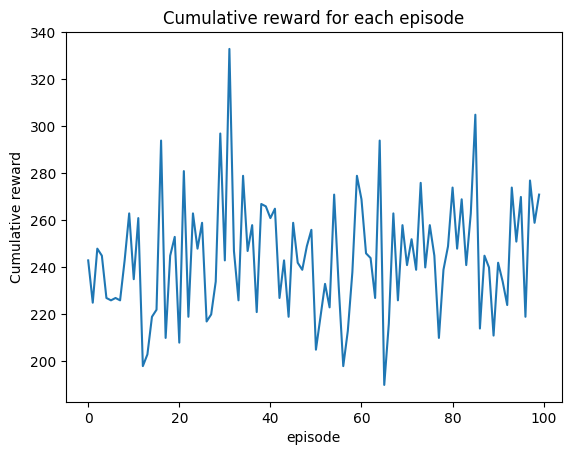

In [11]:
plt.plot(total_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [12]:
print("Average cumulative reward:", sum(total_rewards) / len(total_rewards))
print("Is my agent good enough?", sum(total_rewards) / len(total_rewards) > 195)

Average cumulative reward: 244.3
Is my agent good enough? True


## Task 3: Render one episode played by the agent

### Steps taken:

Similar to Task 2, but instead a single epsiode is recorded instead. Using `RecordVideo`, the environment is simulated with one episode and recorded.

In [13]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
state = wrapper(observation, device='cpu').unsqueeze(0)

model = DQN(env.observation_space, env.action_space, 128).to(device='cpu')

state_dict = torch.load('DQNwithTargetNet.pth') # loads the weights of the model
model.load_state_dict(state_dict)
model.eval()

while True:
    env.render()
    action = model(state).argmax().item()
    observation, reward, done, info = env.step(action)
    state = wrapper(observation, device='cpu').unsqueeze(0) # obtain the next state after executing action that was recommended
    if done:
      break;

print("terminate")
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


terminate


### References:
1. To build our DQN Model we will be using the PyTorch library and we referenced code from
<br>https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html <br>https://stackoverflow.com/questions/75179713/problem-getting-dqn-to-learn-cartpole-v1-pytorch

2. For our research on DQN and Target Network we referenced
<br>https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b
<br>https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html